# Multi-dimer NF-κB model

The below code will create the multi-dimer NF-κB model as parameterised in the upcoming Science Signalling Paper and run it canonical activation, non-canonical activation and differing basal (steady state) activation of NEMO IKK. It will run all models with the conditions specified which by default are: WT, high cRel and high RelA, to explore how these things interact within the NFκB network.

Make sure you have a julia kernel selected that has many threads. Here is how many threads you have available:

In [1]:
import Base.Threads
Threads.nthreads()

4

In [2]:
function runSimulationNFkB(first_cell, last_cell, conditions,folder,IKKSSArray,IKKTCArray,NIKSSArray,NIKTCArray)
    mkpath(folder)
    #now lets loop through and solve the cell
    TCLength=1000*60
    maximumAttemptsAtSS=10
    include("variableNames.jl")
    include("scanIncludes.jl")
    originalParams=copy(paramVals)
    ikkIndex=findfirst(x -> x=="ikk1_ikkactivity", parameterNameList)
    NIKIndex=findfirst(x -> x=="nik_deg_mod", parameterNameList)
    
    thisDist=TruncatedNormal(1.0, preCV,0,Inf)


    Random.seed!(123)    


    allParams=[]
    allParams=Array{Any}(undef, size(parametersDF,1), last_cell)
    for cellIndex in first_cell:last_cell
        thisCellsParamVals=copy(originalParams)            

        for j in 1:size(parametersDF,1)
            if parametersDF[j,3]==1
                x = rand(thisDist, 1)
               thisCellsParamVals[j]=thisCellsParamVals[j].*x[1]
            end
        end
        #println(thisCellsParamVals)
        allParams[:,cellIndex]=thisCellsParamVals
    end
    df = DataFrame(allParams,:auto)
    #add the variable names and save to a file
    insertcols!(df, 1, :names=>parameterNameList)

    CSV.write(folder*"/allParams_runSimulationNew.csv",df);
    #println(size(allParams))
    #println(allParams[1])
    allParamsOriginal=copy(allParams)
    for condIndex in 1:length(conditions)
        allParams=copy(allParamsOriginal)
        thisCondition = conditions[condIndex]
        #TODO: consider making a condition scaling factor array here and just multiplying all prameters by it every time.
        
        println("Starting condition: "*thisCondition)
        odeName="odeModel"
        myFun=getfield(Main,Symbol(odeName))

        #define the function and the initial conditions
        f=ODEFunction(myFun,syms=Symbol.(syms))
        y0=zeros(length(syms))
    
        paramsListInThisCondition=paramsToChange[condIndex]
        modifyListInThisCondition=modifyAmount[condIndex]

        for thisParamIndex in 1:length(paramsListInThisCondition)
            thisParam=paramsListInThisCondition[thisParamIndex]
            thisParamsIndexInParamList=findfirst(x->x==thisParam,parameterNameList)
            allParams[thisParamsIndexInParamList,:]=allParams[thisParamsIndexInParamList,:].*modifyListInThisCondition[thisParamIndex]
        end  
        df = DataFrame(allParams,:auto)
        #add the variable names and save to a file
        insertcols!(df, 1, :names=>parameterNameList)
        CSV.write(folder*"/allParams_runSimulationNew_"*thisCondition*".csv",df);

        Threads.@threads for i in first_cell:last_cell
            #figure out the name of this cell's ode file
            
            #DISTRIBUTE PARAMS
            
            println("starting cell: "*string(i))
            thisCellsParamVals=copy(allParams[:,i])
            thisCellsParamVals[ikkIndex]=IKKSSArray[condIndex]
            thisCellsParamVals[NIKIndex]=NIKSSArray[condIndex]
            
      
    #     #now write this condition's CSV file to a folder of cells
    #     CSV.write(generatedCSVLocation*"/parameters_"*string(conditions[condIndex])*".csv", thisCondParamFile)

            prob=ODEProblem(f,y0,(0.0,maxTimeSS),thisCellsParamVals)

            solss=solve(prob,saveat=100.0,progress = true)
            println("Steady state found for cell: "*string(i))

            #dynamic phase, use SS solution as initial conditions
            y0=vec(convert(Array, solss[:,end]))
            y0[y0.<0].=0
            thisCellsParamVals[ikkIndex]=IKKTCArray[condIndex]
            thisCellsParamVals[NIKIndex]=NIKTCArray[condIndex]
            #CSV.write(generatedCSVLocation*"/parameters_"*string(conditions[condIndex])*"_cell_"*string(i)*".csv", DataFrame(thisCellsParamVals,:auto))
            try
                f=ODEFunction(myFun,syms=syms)
                prob=ODEProblem(f,y0,(0.0,maxTimeTC),thisCellsParamVals)
                println("Solving equations for dynamic time course for cell:"*string(i))
                sol=solve(prob, abstol=1e-5,reltol=1e-3, saveat=1.0)
                #save("outputs/sol_"*thisCondition*"_cell_"*string(i)*".jld2", "solution", sol)
                df = DataFrame(Float64.(sol),:auto)
                #add the variable names and save to a file
                insertcols!(df, 1, :names=>syms)
                #CSV.write("outputs/sol_"*thisCondition*"_cell_"*string(i)*".csv",Tables.columntable(df));
                CSV.write(folder*"/sol_"*thisCondition*"_cell_"*string(i)*".csv",df);
            catch e
                println("error:")
                println(e)
            end

        end
        println("all cells done in condition: "*thisCondition)

    end
end

runSimulationNFkB (generic function with 1 method)

In [3]:
#this is an old version please don't copy, find the plotAllSpecies.jl from somewhere recent
function plotAllSpecies(speciesToPlot,conditionsToPlot,colorArray,first_cell,last_cell,folder,hoursToPlot,maxValOfYAxis)
    for species in speciesToPlot
        #thisPlot=plot(title=species)
        thisPlotStd=plot(title=species*" avg",legend=:none)
        boxPlotAll=plot(title=species*" ss",legend=:none)
        BoxPlotAvg=plot(title=species*"avg ss")
        conditionIndex=1
        meansOfAllConditions=zeros(1,length(conditionsToPlot))
        stdOfAllConditions=zeros(1,length(conditionsToPlot))
        lengthOfTC=0
        for condition in conditionsToPlot
            lengthOfTC=size(DataFrame(CSV.File(folder*"/sol_"*condition*"_cell_1.csv")),2)-1

            conditionArray=zeros(last_cell,lengthOfTC)
            lineColor=colorArray[conditionIndex]
            virtExpFlag=false
            for i in first_cell:last_cell
                thisCellData=DataFrame(CSV.File(folder*"/sol_"*condition*"_cell_"*string(i)*".csv"))
                if !("names" in names(thisCellData))
                    insertcols!(thisCellData, 1, :names=>syms)
                end
                allNoneFloats=findall(eltype.(eachcol(thisCellData)).!=Float64)
                if length(allNoneFloats)>1
                    for index in allNoneFloats[2:end]
                        thisCellData[!,index]=parse.(Float64,thisCellData[:,index])
                    end
                end
                thisTC=zeros(1,size(thisCellData,2)-1)
                if endswith(species,"*")
                    virtExpFlag=true
                    speciesShort=species[1:end-1]
                    speciesIDs=intersect(findall( x ->occursin(speciesShort,x),syms),findall(x->!startswith(x,"t"),syms))
                    speciesNames=String.(syms[speciesIDs])
#                     println("For species: "*species*" printing: ")
#                     println(speciesNames)
                    for thisName in speciesNames
                        thisSpeciesTC=Matrix(thisCellData[thisCellData[!,:names].==thisName,:])[2:end]
                        
                        thisTC=thisTC.+thisSpeciesTC'
                    end
                else
                    thisTC=Matrix(thisCellData[thisCellData[!,:names].==species,:])[2:end]
                end
                conditionArray[i,:]=thisTC[1:lengthOfTC]


            end

            df = DataFrame(Float64.(conditionArray),:auto)
            #add the variable names and save to a file
            #CSV.write("outputs/sol_"*thisCondition*"_cell_"*string(i)*".csv",Tables.columntable(df));
            CSV.write("outputs/allTCs_"*species*"_cell.csv",df);

            
            meanOfCondition=mean(conditionArray, dims=1)
            stdOfCondition=std(conditionArray, dims=1)
#             println(meanOfCondition)
#             println(stdOfCondition)
            plot!(thisPlotStd,meanOfCondition',grid=false,color=lineColor,ribbon=stdOfCondition',fillalpha=.5,label=condition,linewidth=5)

            meansOfAllConditions[conditionIndex]=meanOfCondition[1]
            stdOfAllConditions[conditionIndex]=stdOfCondition[1]

            conditionIndex+=1
        end
        conditionIndex=1
        #plot!(boxPlotAll,conditionsToPlot, meansOfAllConditions;, c=colorArray, yerr = stdOfAllConditions', label = "",xrotation = 90,seriestype = :scatter,fillcolor=:match)
        for condition in conditionsToPlot
            plot!(boxPlotAll,[conditionIndex], [meansOfAllConditions[conditionIndex]], c=colorArray[conditionIndex], yerr = stdOfAllConditions[conditionIndex], label = false,xrotation = 90,seriestype = :scatter,fillcolor=:match,markersize=20,markerstrokewidth=5)            
            conditionIndex+=1
        end
        plot!(boxPlotAll,xticks = (1:length(conditions), conditions),xlim=(0,length(conditionsToPlot)+1),ylim=(0,maximum([maximum(meansOfAllConditions)+maximum(stdOfAllConditions),maxValOfYAxis])),dpi=300,size=(0.8*[800,1000]),xtickfontsize=18,ytickfontsize=18)        
        plot!(thisPlotStd,xticks=(collect(0:60:lengthOfTC),collect(0:1:lengthOfTC/60)),ylim=(0,maxValOfYAxis),xlim=(0,hoursToPlot*60),dpi=300,size=([1500*0.6,1000*0.8]),xtickfontsize=18,ytickfontsize=18)

        #display(plot(boxPlotAll,thisPlot))
        display(plot(boxPlotAll,thisPlotStd,layout = grid(1, 2, widths=[0.4 ,0.6])))
    end
end
plotly()

LoadError: UndefVarError: plotly not defined

In [4]:
#packages we need
using Pkg
Pkg.add("DifferentialEquations")
Pkg.add("Plots")
Pkg.add("CSV")
Pkg.add("Distributions")
Pkg.add("Random")
Pkg.add("DataFrames")
Pkg.add("JLD2")
Pkg.add("FileIO")
Pkg.add("StatsPlots")
Pkg.add("Statistics")
Pkg.add(Pkg.PackageSpec(;name="Parsers", version="2.2.4"))
using DifferentialEquations
using Plots 
using Pkg
Pkg.add(Pkg.PackageSpec(;name="Parsers", version="2.2.4"))
using CSV
using Distributions
using Random
using DataFrames
using JLD2
using FileIO
using StatsPlots
using Plots.PlotMeasures
using Statistics
using Dates
colorArray=palette(:seaborn_colorblind)
delay=false

    Updating registry at `~/.julia/registries/General`
    Updating git-repo `https://github.com/JuliaRegistries/General.git`
   Resolving package versions...
  No Changes to `~/.julia/environments/v1.8/Project.toml`
  No Changes to `~/.julia/environments/v1.8/Manifest.toml`
   Resolving package versions...
  No Changes to `~/.julia/environments/v1.8/Project.toml`
  No Changes to `~/.julia/environments/v1.8/Manifest.toml`
   Resolving package versions...
  No Changes to `~/.julia/environments/v1.8/Project.toml`
  No Changes to `~/.julia/environments/v1.8/Manifest.toml`
   Resolving package versions...
  No Changes to `~/.julia/environments/v1.8/Project.toml`
  No Changes to `~/.julia/environments/v1.8/Manifest.toml`
   Resolving package versions...
  No Changes to `~/.julia/environments/v1.8/Project.toml`
  No Changes to `~/.julia/environments/v1.8/Manifest.toml`
   Resolving package versions...
  No Changes to `~/.julia/environments/v1.8/Project.toml`
  No Changes to `~/.julia/environ

false

In [65]:
#fix the death ligand concentration
t=0
include("distributedModelFiles/odeModel.jl")
include("variableNames.jl")
include("scanIncludes.jl")
include("runSimulationNFkB.jl")
# include("runSimulationSaveSS.jl")
include("plotAllSpecies2.jl")
# include("plotAllSpeciesSS.jl");
include("denseIKKNIKheatmap.jl");
include("denseheatmapSS.jl");

parameters can now be searched in parameterNameList by name.
example to modify k_binding 1.5 fold higher:
indexOfParam=findfirst(x->"k_binding"==x,parameterNameList)
paramVals[indexOfParam]=paramVals[indexOfParam]*1.5


In [6]:
first_cell=1
last_cell=1

#set up where CSV2Julia is
#from: https://github.com/SiFTW/CSV2JuliaDiffEq
locationOfCSV2Julia="csv2model-multiscale.py"

#identify the three CSV sheets that describe the model
reactionsFile="moduleDefinitionFiles/NFkB/updated_NFkB_reactions.csv"
parametersFile="moduleDefinitionFiles/NFkB/parameters.csv"
rateLawsFile="moduleDefinitionFiles/NFkB/rateLaws.csv"
generatedCSVLocation="generatedCSVs/"
distributedModelFilesLocation="distributedModelFiles/"


mkpath(generatedCSVLocation)
mkpath(distributedModelFilesLocation)

totalIKK=140
total_WT_IKK=totalIKK*1.0
basalIKK=totalIKK/100
IKKMultiplier=1
maxTimeSS=100000.0
maxTimeTC=60*8
preCV=0.11;
#preCV=0.0

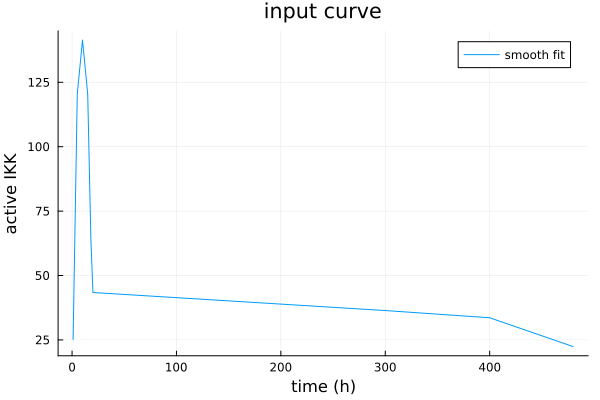

In [7]:
function ikkDefault(t,maxTime)
    #explicitely defined input
    IKKparamVals=[0,85,100,85,45,30,25,23,18,15,12,10,10]./100
    paramTime=[0,5,10,15,18,20,300,400,450,480,500,520,max(maxTime,2880)]
    #get the value after the current time point
    indexGTTime=min(searchsortedfirst(paramTime,t),length(paramTime))
    #get the one before
    indexLTTime=max(1,indexGTTime-1)
    timeGTt=paramTime[indexGTTime]
    timeLTt=paramTime[indexLTTime]
    valGTt=IKKparamVals[indexGTTime]
    valLTt=IKKparamVals[indexLTTime]
    timeDiff=timeGTt-timeLTt
    #if the time before and time after are different do a basic linear interpolation between the two.
    if timeDiff>0
        valDiff=valGTt-valLTt
        gradient=valDiff/timeDiff
        timeStep=t-timeLTt
        return valLTt+(gradient*timeStep)
    else
        return valLTt
    end
end

function NIKDefault(t,maxTime=2880)
    #explicitely defined input
    NIKparamVals=[1,50,100,180,200,100,50]./100
    paramTime=[0,60,120,300,400,800,max(maxTime,2880)]
    #get the value after the current time point
    indexGTTime=min(searchsortedfirst(paramTime,t),length(paramTime))
    #get the one before
    indexLTTime=max(1,indexGTTime-1)
    timeGTt=paramTime[indexGTTime]
    timeLTt=paramTime[indexLTTime]
    valGTt=NIKparamVals[indexGTTime]
    valLTt=NIKparamVals[indexLTTime]
    timeDiff=timeGTt-timeLTt
    #if the time before and time after are different do a basic linear interpolation between the two.
    if timeDiff>0
        valDiff=valGTt-valLTt
        gradient=valDiff/timeDiff
        timeStep=t-timeLTt
        return valLTt+(gradient*timeStep)
    else
        return valLTt
    end
end

#the IKK function is just maps to basal IKK during SS and basal+the IKK curve during the time course.
ikkSS=t->basalIKK
ikkTC=t->basalIKK+(ikkDefault(t, maxTimeTC)*IKKMultiplier*totalIKK);
ikkTCWT=t->basalIKK+(ikkDefault(t, maxTimeTC)*IKKMultiplier*total_WT_IKK);
ikkCurveForLine=[ikkTCWT]
ikkFunc=ikkTCWT
NIKFuncSS=t->1
NIKFuncTC=t->0
ikkSSHigh=t->basalIKKHigh

p=plot([1:1:maxTimeTC],ikkTC.(1:1:maxTimeTC),label="smooth fit",title="input curve");
xlabel!("time (h)")
ylabel!("active IKK")

The below code first creates the ODE file.

In [8]:
parametersDF = DataFrame(CSV.File(parametersFile,types=Dict(:parameter=>String, :value=>String, :distribute=>Int64)))
originalParams=deepcopy(parametersDF)

thisModelName="odeModel.jl"
thisParamFile=parametersFile
arguments=[reactionsFile, thisParamFile, rateLawsFile,thisModelName]
cmd=`python3 $locationOfCSV2Julia $arguments param`

#lets run csv2julia (requires python to be installed)
run(cmd)

include(thisModelName)
mv(thisModelName,"distributedModelFiles/"*thisModelName, force=true)
println("Model generated for all conditions")

param
Running CSV2JuliaDiffEq with parameters dynamically determined by a variable, re-run with the 5th argument set to 'scan' or 'inline'
Opening moduleDefinitionFiles/NFkB/rateLaws.csv as rate law file
Opening moduleDefinitionFiles/NFkB/parameters.csv as parameters file
Opening moduleDefinitionFiles/NFkB/updated_NFkB_reactions.csv as reactions file
Model generated for all conditions


The below function will run the number of cells you specify, with the conditions you specify and the input curves specified. It will use multiple threads to do so and save the results in a different folder for each condition.

In [9]:
include("runSimulationNFkB.jl")
include("plotAllSpecies2.jl")

plotAllSpecies2 (generic function with 1 method)

The below code is used to plot some graphs. It will plot the species you specify and compare between each condition. It will plot both steady state values (as bar graphs on the left), and time courses (as line graphs on the right). IT will calculate the standard deviation and mean of each cell populationin each condition and show thenm as error regions.

First we'll run the WT condition with with IKK inputs, followed by repeating the simulations with 10X RelA synthesis and 10x cRel synthesis. We specify and output folder so that the next simulations we run can go to a different folder.

now we'll simulate the effect of different levels of basal activity. (both IKK and NIK)

I define all the steady state and the TC states for both IKK and NIK. Reminder: during TC only one of them will be switched on and using the TC trajectory.

In [10]:
maxTimeTC=40*60

NIKFuncSS05(t)=2
NIKFuncSS1(t)=1
NIKFuncSS2(t)=1/2
NIKFuncSS5(t)=1/5
NIKFuncSS10(t)=1/10
NIKFuncSS50(t)=1/50
NIKFuncSS100(t)=1/100
NIKFuncSS1000(t)=1/1000

#nikTC were made by Arran on 27/02/23
nikTC05(t)=NIKDefault(t, maxTimeTC) - 0.5
nikTC1(t)=NIKDefault(t, maxTimeTC)+0
nikTC2(t)=NIKDefault(t, maxTimeTC)+1/2
nikTC5(t)=NIKDefault(t, maxTimeTC)+1/5
nikTC10(t)=NIKDefault(t, maxTimeTC)+1/10
nikTC50(t)=NIKDefault(t, maxTimeTC)+1/50
nikTC100(t)=NIKDefault(t, maxTimeTC)+1/100
nikTC1000(t)=NIKDefault(t, maxTimeTC)+1/1000
#nikTC were made by Arran on 27/02/23

maxTimeTC=8*60
ikkSS1(t)=basalIKK.*1
ikkSS2(t)=basalIKK.*2
ikkSS5(t)=basalIKK.*5
ikkSS10(t)=basalIKK.*10
ikkSS50(t)=basalIKK.*50
ikkSS100(t)=basalIKK.*100
ikkSS1000(t)=basalIKK.*1000

ikkTC1(t)=basalIKK.*1+(ikkDefault(t, maxTimeTC)*IKKMultiplier*totalIKK)
ikkTC2(t)=basalIKK.*2+(ikkDefault(t, maxTimeTC)*IKKMultiplier*totalIKK)
ikkTC5(t)=basalIKK.*5+(ikkDefault(t, maxTimeTC)*IKKMultiplier*totalIKK)
ikkTC10(t)=basalIKK.*10+(ikkDefault(t, maxTimeTC)*IKKMultiplier*totalIKK)
ikkTC50(t)=basalIKK.*50+(ikkDefault(t, maxTimeTC)*IKKMultiplier*totalIKK)
ikkTC100(t)=basalIKK.*100+(ikkDefault(t, maxTimeTC)*IKKMultiplier*totalIKK)
ikkTC1000(t)= basalIKK.*1000+(ikkDefault(t, maxTimeTC)*IKKMultiplier*totalIKK)

# IKKSSArray=[ikkSS1,ikkSS2,ikkSS5,ikkSS10,ikkSS50,ikkSS100,ikkSS1000]
# IKKTCArray=[ikkTC1,ikkTC2,ikkTC5,ikkTC10,ikkTC50,ikkTC100,ikkTC1000]
# NIKSSArray=[NIKFuncSS1,NIKFuncSS2,NIKFuncSS5,NIKFuncSS10,NIKFuncSS50,NIKFuncSS100,NIKFuncSS1000]
# NIKTCArray=[NIKFuncSS1,NIKFuncSS2,NIKFuncSS5,NIKFuncSS10,NIKFuncSS50,NIKFuncSS100,NIKFuncSS1000]
# println("Summary of conditions being run:")
# show(IOContext(stdout, :limit => false), "text/plain", hcat(conditions,paramsToChange,modifyAmount))
# folder="outputs/totalActivityBasalScan"
# runSimulationNew(first_cell,last_cell,conditions,folder,IKKSSArray,IKKTCArray,NIKSSArray,NIKTCArray)

ikkTC1000 (generic function with 1 method)

Firstly, the heatmap where CANONICAL stimulation occurs in the TC.

This cell generates the list of conditions.

In [11]:
rows=7
columns=8
blocksinheatmap=rows*columns
rowConsToUseSS=[ikkSS1,ikkSS2,ikkSS5,ikkSS10,ikkSS50,ikkSS100,ikkSS1000][1:rows]
columnConsToUseSS=[NIKFuncSS05,NIKFuncSS1,NIKFuncSS2,NIKFuncSS5,NIKFuncSS10,NIKFuncSS50,NIKFuncSS100,NIKFuncSS1000][1:columns]
rowConsToUse=[ikkTC1,ikkTC2,ikkTC5,ikkTC10,ikkTC50,ikkTC100,ikkTC1000][1:rows]
columnConsToUse=[NIKFuncSS05,NIKFuncSS1,NIKFuncSS2,NIKFuncSS5,NIKFuncSS10,NIKFuncSS50,NIKFuncSS100,NIKFuncSS1000][1:columns]

                            # columns=1
                            # rows=7
                            # columnConsToUseSS=[NIKFuncSS05]
                            # columnConsToUse=[NIKFuncSS05]


paramsToChange=repeat([["k1_RelASynth"]],blocksinheatmap)
modifyAmount=repeat([1.0],blocksinheatmap)

canonConditions=[]
print("basal conditions as follows:   ")
for ikkb in rowConsToUse
    ikkbasal=string(ikkb)
    for nikb in columnConsToUse
        nikbasal=string(nikb)
        push!(canonConditions,string("canon_",ikkbasal,"_",nikbasal))
        print(",",'"',"canon_",ikkbasal,"_",nikbasal,'"')
    end
end
NIKSSArray=repeat(columnConsToUseSS,rows)
NIKTCArray=repeat(columnConsToUse,rows)
IKKSSArray=repeat(rowConsToUseSS,inner=columns)
IKKTCArray=repeat(rowConsToUse,inner=columns)

# least,most,middle,maxikk,maxnik
fiveCornerCanonConditions=["canon_ikkTC1_NIKFuncSS1","canon_ikkTC1000_NIKFuncSS1000","canon_ikkTC10_NIKFuncSS10","canon_ikkTC1000_NIKFuncSS1","canon_ikkTC1_NIKFuncSS1000"]
sevenCornerCanonConditions=["canon_ikkTC1_NIKFuncSS1","canon_ikkTC1000_NIKFuncSS1000","canon_ikkTC10_NIKFuncSS10","canon_ikkTC1000_NIKFuncSS1","canon_ikkTC1_NIKFuncSS1000","canon_ikkTC1_NIKFuncSS05","canon_ikkTC1000_NIKFuncSS05"]


basal conditions as follows:   ,"canon_ikkTC1_NIKFuncSS05","canon_ikkTC1_NIKFuncSS1","canon_ikkTC1_NIKFuncSS2","canon_ikkTC1_NIKFuncSS5","canon_ikkTC1_NIKFuncSS10","canon_ikkTC1_NIKFuncSS50","canon_ikkTC1_NIKFuncSS100","canon_ikkTC1_NIKFuncSS1000","canon_ikkTC2_NIKFuncSS05","canon_ikkTC2_NIKFuncSS1","canon_ikkTC2_NIKFuncSS2","canon_ikkTC2_NIKFuncSS5","canon_ikkTC2_NIKFuncSS10","canon_ikkTC2_NIKFuncSS50","canon_ikkTC2_NIKFuncSS100","canon_ikkTC2_NIKFuncSS1000","canon_ikkTC5_NIKFuncSS05","canon_ikkTC5_NIKFuncSS1","canon_ikkTC5_NIKFuncSS2","canon_ikkTC5_NIKFuncSS5","canon_ikkTC5_NIKFuncSS10","canon_ikkTC5_NIKFuncSS50","canon_ikkTC5_NIKFuncSS100","canon_ikkTC5_NIKFuncSS1000","canon_ikkTC10_NIKFuncSS05","canon_ikkTC10_NIKFuncSS1","canon_ikkTC10_NIKFuncSS2","canon_ikkTC10_NIKFuncSS5","canon_ikkTC10_NIKFuncSS10","canon_ikkTC10_NIKFuncSS50","canon_ikkTC10_NIKFuncSS100","canon_ikkTC10_NIKFuncSS1000","canon_ikkTC50_NIKFuncSS05","canon_ikkTC50_NIKFuncSS1","canon_ikkTC50_NIKFuncSS2","canon_ikkTC50

7-element Vector{String}:
 "canon_ikkTC1_NIKFuncSS1"
 "canon_ikkTC1000_NIKFuncSS1000"
 "canon_ikkTC10_NIKFuncSS10"
 "canon_ikkTC1000_NIKFuncSS1"
 "canon_ikkTC1_NIKFuncSS1000"
 "canon_ikkTC1_NIKFuncSS05"
 "canon_ikkTC1000_NIKFuncSS05"

In [12]:
include("runSimulationNFkB.jl")
parametersDF = DataFrame(CSV.File(parametersFile,types=Dict(:parameter=>String, :value=>String, :distribute=>Int64)))
originalParams=deepcopy(parametersDF)
folder="output/IKKNIKbasalscanforheatmap"


"output/IKKNIKbasalscanforheatmap"

In [13]:
# runSimulationNFkB(first_cell,last_cell,canonConditions,folder,IKKSSArray,IKKTCArray,NIKSSArray,NIKTCArray)

In [64]:
denseIKKNIKheatmap(["RelAnp50n"],canonConditions,columns,rows)
denseIKKNIKheatmap(["RelAnp52n"],canonConditions,columns,rows)
denseIKKNIKheatmap(["RelAn*"],canonConditions,columns,rows)
denseIKKNIKheatmap(["RelA*"],canonConditions,columns,rows)
denseIKKNIKheatmap(["RelAp50IkBa"],canonConditions,columns,rows)
denseIKKNIKheatmap(["RelAp50IkBd"],canonConditions,columns,rows)


denseIKKNIKheatmap(["IkBdNIK"],canonConditions,columns,rows)
denseIKKNIKheatmap(["IkBa*"],canonConditions,columns,rows)
denseIKKNIKheatmap(["IkBd*"],canonConditions,columns,rows)
denseIKKNIKheatmap(["p100*"],canonConditions,columns,rows)

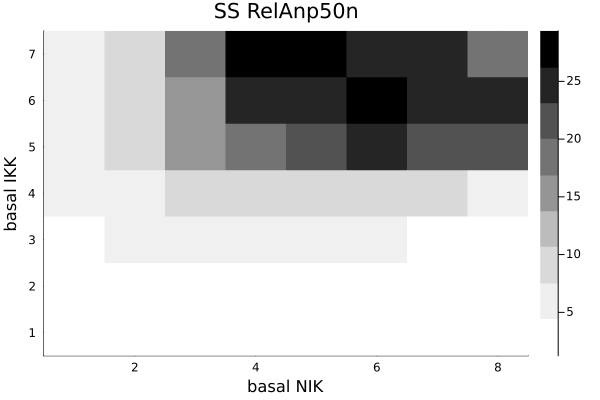

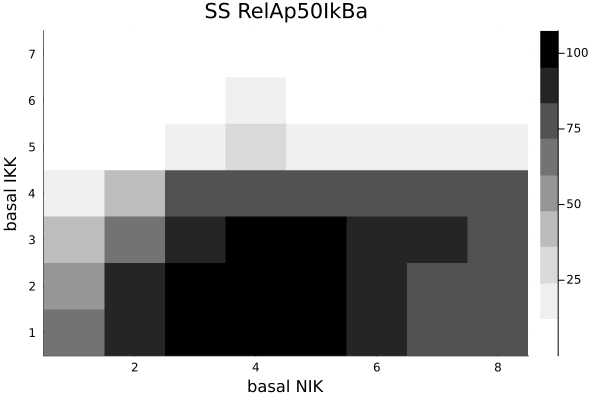

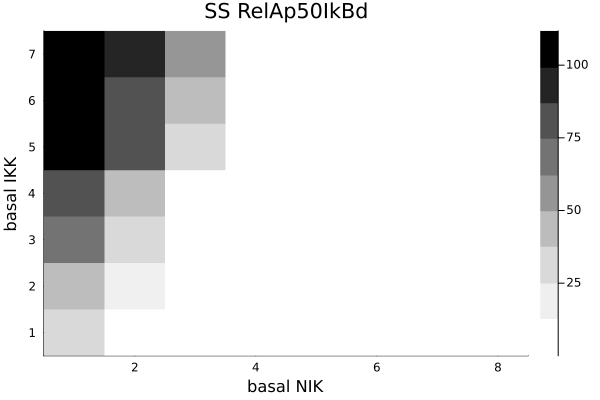

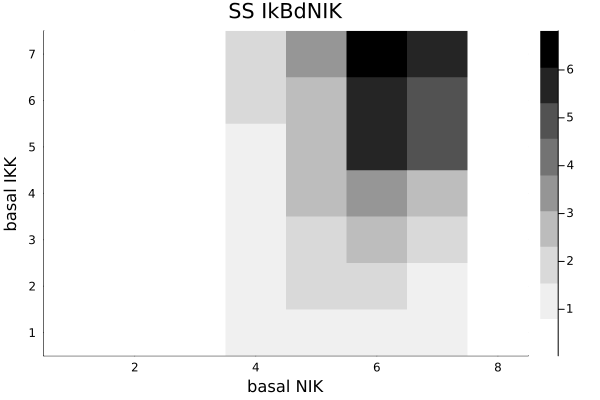

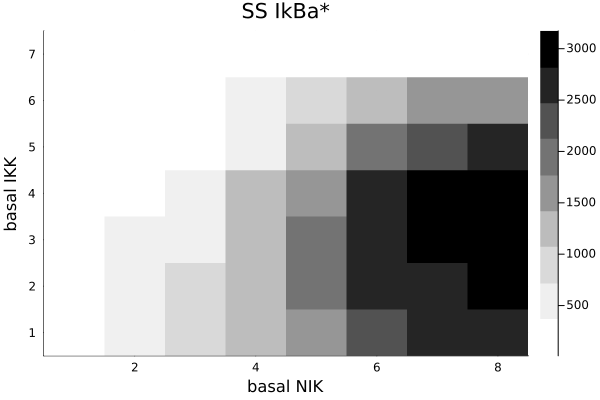

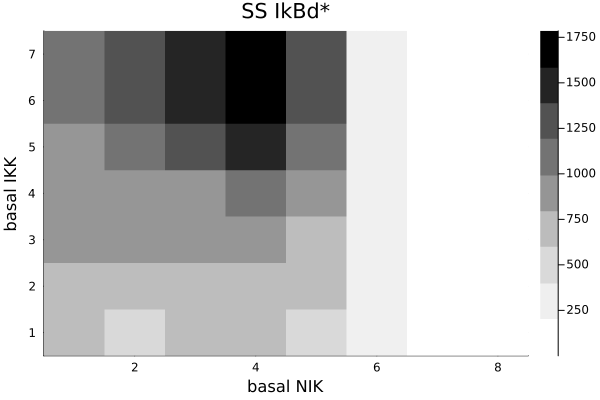

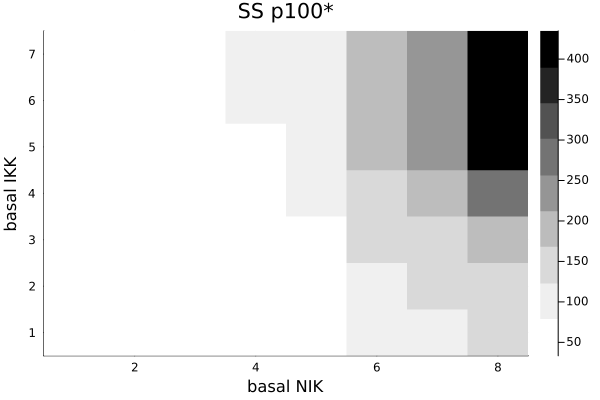

In [15]:
denseheatmapSS(["RelAnp50n"],canonConditions,columns,rows)
denseheatmapSS(["RelAp50IkBa"],canonConditions,columns,rows)
denseheatmapSS(["RelAp50IkBd"],canonConditions,columns,rows)
denseheatmapSS(["IkBdNIK"],canonConditions,columns,rows)
denseheatmapSS(["IkBa*"],canonConditions,columns,rows)
denseheatmapSS(["IkBd*"],canonConditions,columns,rows)
denseheatmapSS(["p100*"],canonConditions,columns,rows)

In [16]:
maxValOfYAxis=550
plotAllSpecies2(["RelAp50IkBa*"],fiveCornerCanonConditions,colorArray,first_cell,last_cell,folder,hoursToPlot,maxValOfYAxis,qualityScaling)
maxValOfYAxis=550
plotAllSpecies2(["RelAp50IkBd*"],fiveCornerCanonConditions,colorArray,first_cell,last_cell,folder,hoursToPlot,maxValOfYAxis,qualityScaling)

LoadError: UndefVarError: hoursToPlot not defined

In [17]:
maxValOfYAxis=1000
plotAllSpecies2(["RelAnp52n"],fiveCornerCanonConditions,colorArray,first_cell,last_cell,folder,hoursToPlot,maxValOfYAxis,qualityScaling)
maxValOfYAxis=500
plotAllSpecies2(["p52*"],fiveCornerCanonConditions,colorArray,first_cell,last_cell,folder,hoursToPlot,maxValOfYAxis,qualityScaling)


LoadError: UndefVarError: hoursToPlot not defined

In [18]:
colorArray=palette(:YlGn,50)
colorArray=palette(:seaborn_colorblind)
hoursToPlot=9
qualityScaling=1
maxValOfYAxis=100
plotAllSpecies2(["RelAnp50n"],sevenCornerCanonConditions,colorArray,first_cell,last_cell,folder,hoursToPlot,maxValOfYAxis,qualityScaling)
maxValOfYAxis=3.4
plotAllSpecies2(["IkBdNIK"],fiveCornerCanonConditions,colorArray,first_cell,last_cell,folder,hoursToPlot,maxValOfYAxis,qualityScaling)
maxValOfYAxis=1000
plotAllSpecies2(["RelBp52IkBd"],fiveCornerCanonConditions,colorArray,first_cell,last_cell,folder,hoursToPlot,maxValOfYAxis,qualityScaling)
maxValOfYAxis=1600
plotAllSpecies2(["IkBd*"],fiveCornerCanonConditions,colorArray,first_cell,last_cell,folder,hoursToPlot,maxValOfYAxis,qualityScaling)
maxValOfYAxis=550
plotAllSpecies2(["p100*"],fiveCornerCanonConditions,colorArray,first_cell,last_cell,folder,hoursToPlot,maxValOfYAxis,qualityScaling)
maxValOfYAxis=4000
plotAllSpecies2(["IkBa*"],fiveCornerCanonConditions,colorArray,first_cell,last_cell,folder,hoursToPlot,maxValOfYAxis,qualityScaling)


In [19]:
folder

"output/IKKNIKbasalscanforheatmap"

In [20]:
plotly()
r=reshape([1,1,1,1,2,2,2,2,3,3,3,3],(4,3))
heatmap(rotateRectMatrix(r),colour=palette(:YlGn))

┌ Warning: For saving to png with the `Plotly` backend `PlotlyBase` and `PlotlyKaleido` need to be installed.
│   err =
│    ArgumentError: Package PlotlyBase not found in current path.
│    - Run `import Pkg; Pkg.add("PlotlyBase")` to install the PlotlyBase package.
└ @ Plots ~/.julia/packages/Plots/M4dfL/src/backends.jl:545


Secondly, the heatmap where NONCANONICAL stimulation occurs in the TC.

In [44]:
println("The NIK stimulation spike")
nlist=[]
for n in range(1,2900,step=1)
    push!(nlist,NIKDefault(n,2880))
end
plot(nlist,title="NIK stim curve")

The NIK stimulation spike


In [46]:
rows=7
columns=8
blocksinheatmap=rows*columns
rowConsToUseSS=[ikkSS1,ikkSS2,ikkSS5,ikkSS10,ikkSS50,ikkSS100,ikkSS1000][1:rows]
columnConsToUseSS=[NIKFuncSS05,NIKFuncSS1,NIKFuncSS2,NIKFuncSS5,NIKFuncSS10,NIKFuncSS50,NIKFuncSS100,NIKFuncSS1000][1:columns]
rowConsToUse=[ikkSS1,ikkSS2,ikkSS5,ikkSS10,ikkSS50,ikkSS100,ikkSS1000][1:rows]
columnConsToUse=[nikTC05,nikTC1,nikTC2,nikTC5,nikTC10,nikTC50,nikTC100,nikTC1000][1:columns]
paramsToChange=repeat([["k1_RelASynth"]],blocksinheatmap)
modifyAmount=repeat([1.0],blocksinheatmap)

#                 rows=7
#                 columns=1
#                 columnConsToUseSS=[NIKFuncSS05,NIKFuncSS1,NIKFuncSS2,NIKFuncSS5,NIKFuncSS10,NIKFuncSS50,NIKFuncSS100,NIKFuncSS1000]
#                 columnConsToUse=[nikTC05]

noncanonConditions=[]
print("basal conditions as follows:   ")
for ikkb in rowConsToUse
    ikkbasal=string(ikkb)
    for nikb in columnConsToUse
        nikbasal=string(nikb)
        push!(noncanonConditions,string("noncanon_",ikkbasal,"_",nikbasal))
        print(",",'"',"noncanon_",ikkbasal,"_",nikbasal,'"')
    end
end
NIKSSArray=repeat(columnConsToUseSS,rows)
NIKTCArray=repeat(columnConsToUse,rows)
IKKSSArray=repeat(rowConsToUseSS,inner=columns)
IKKTCArray=repeat(rowConsToUse,inner=columns);

# least,most,middle,maxikk,maxnik
fiveCornerNonCanonConditions=["noncanon_ikkSS1_nikTC1","noncanon_ikkSS1000_nikTC1000","noncanon_ikkSS10_nikTC10","noncanon_ikkSS1000_nikTC1","noncanon_ikkSS1_nikTC1000"]
sevenCornerNonCanonConditions=["noncanon_ikkSS1_nikTC1","noncanon_ikkSS1000_nikTC1000","noncanon_ikkSS10_nikTC10","noncanon_ikkSS1000_nikTC1","noncanon_ikkSS1_nikTC1000","noncanon_ikkSS1_nikTC05","noncanon_ikkSS1000_nikTC05"]

basal conditions as follows:   ,"noncanon_ikkSS1_nikTC05","noncanon_ikkSS1_nikTC1","noncanon_ikkSS1_nikTC2","noncanon_ikkSS1_nikTC5","noncanon_ikkSS1_nikTC10","noncanon_ikkSS1_nikTC50","noncanon_ikkSS1_nikTC100","noncanon_ikkSS1_nikTC1000","noncanon_ikkSS2_nikTC05","noncanon_ikkSS2_nikTC1","noncanon_ikkSS2_nikTC2","noncanon_ikkSS2_nikTC5","noncanon_ikkSS2_nikTC10","noncanon_ikkSS2_nikTC50","noncanon_ikkSS2_nikTC100","noncanon_ikkSS2_nikTC1000","noncanon_ikkSS5_nikTC05","noncanon_ikkSS5_nikTC1","noncanon_ikkSS5_nikTC2","noncanon_ikkSS5_nikTC5","noncanon_ikkSS5_nikTC10","noncanon_ikkSS5_nikTC50","noncanon_ikkSS5_nikTC100","noncanon_ikkSS5_nikTC1000","noncanon_ikkSS10_nikTC05","noncanon_ikkSS10_nikTC1","noncanon_ikkSS10_nikTC2","noncanon_ikkSS10_nikTC5","noncanon_ikkSS10_nikTC10","noncanon_ikkSS10_nikTC50","noncanon_ikkSS10_nikTC100","noncanon_ikkSS10_nikTC1000","noncanon_ikkSS50_nikTC05","noncanon_ikkSS50_nikTC1","noncanon_ikkSS50_nikTC2","noncanon_ikkSS50_nikTC5","noncanon_ikkSS50_nikTC

7-element Vector{String}:
 "noncanon_ikkSS1_nikTC1"
 "noncanon_ikkSS1000_nikTC1000"
 "noncanon_ikkSS10_nikTC10"
 "noncanon_ikkSS1000_nikTC1"
 "noncanon_ikkSS1_nikTC1000"
 "noncanon_ikkSS1_nikTC05"
 "noncanon_ikkSS1000_nikTC05"

In [33]:
folder="output/IKKNIKbasalscanforheatmap"
include("runSimulationNFkB.jl")


runSimulationNFkB (generic function with 1 method)

In [35]:
#runSimulationNFkB(first_cell,last_cell,noncanonConditions,folder,IKKSSArray,IKKTCArray,NIKSSArray,NIKTCArray)

started job at: 12:27
parameters can now be searched in parameterNameList by name.
example to modify k_binding 1.5 fold higher:
indexOfParam=findfirst(x->"k_binding"==x,parameterNameList)
paramVals[indexOfParam]=paramVals[indexOfParam]*1.5
Start condition noncanon_ikkSS1_nikTC05:cell 1SS TC done noncanon_ikkSS1_nikTC05
Start condition noncanon_ikkSS2_nikTC05:cell 1SS TC done noncanon_ikkSS2_nikTC05
Start condition noncanon_ikkSS5_nikTC05:cell 1SS TC done noncanon_ikkSS5_nikTC05
Start condition noncanon_ikkSS10_nikTC05:cell 1SS TC done noncanon_ikkSS10_nikTC05
Start condition noncanon_ikkSS50_nikTC05:cell 1SS TC done noncanon_ikkSS50_nikTC05
Start condition noncanon_ikkSS100_nikTC05:cell 1SS TC done noncanon_ikkSS100_nikTC05
Start condition noncanon_ikkSS1000_nikTC05:cell 1SS TC done noncanon_ikkSS1000_nikTC05
started: 12:27:50
ended: 12:28:00
10 seconds, 581 milliseconds


In [66]:
plotly()
include("denseIKKNIKheatmap.jl")
denseIKKNIKheatmap(["RelAnp50n"],noncanonConditions,columns,rows,palette(:GnBu))
denseIKKNIKheatmap(["RelAn*"],noncanonConditions,columns,rows,palette(:GnBu))
denseIKKNIKheatmap(["RelA*"],noncanonConditions,columns,rows,palette(:GnBu))
denseIKKNIKheatmap(["RelBnp52n"],noncanonConditions,columns,rows,palette(:GnBu))

denseIKKNIKheatmap(["RelAp50IkBa"],noncanonConditions,columns,rows,palette(:GnBu))
denseIKKNIKheatmap(["RelAp50IkBd"],noncanonConditions,columns,rows,palette(:GnBu))
denseIKKNIKheatmap(["RelAnp52n"],noncanonConditions,columns,rows,palette(:GnBu))


In [27]:
include("denseheatmapSS.jl")
denseheatmapSS(["RelAnp50n"],noncanonConditions,columns,rows)
denseheatmapSS(["RelAp50IkBa"],noncanonConditions,columns,rows)
denseheatmapSS(["RelAp50IkBd"],noncanonConditions,columns,rows)
denseheatmapSS(["RelAnp52n"],noncanonConditions,columns,rows)

qualityScaling=1
hoursToPlot=8
maxValOfYAxis=100/1
plotAllSpecies2(["NIK"],sevenCornerNonCanonConditions,colorArray,first_cell,last_cell,folder,hoursToPlot,maxValOfYAxis,qualityScaling)
plotAllSpecies2(["RelAnp50n"],sevenCornerNonCanonConditions,colorArray,first_cell,last_cell,folder,hoursToPlot,maxValOfYAxis,qualityScaling)

plotAllSpecies2(["RelA*"],sevenCornerNonCanonConditions,colorArray,first_cell,last_cell,folder,hoursToPlot,maxValOfYAxis,qualityScaling)


qualityScaling=1
hoursToPlot=8
maxValOfYAxis=100
plotAllSpecies2(["RelAnp50n"],fiveCornerNonCanonConditions,colorArray,first_cell,last_cell,folder,hoursToPlot,maxValOfYAxis,qualityScaling)
maxValOfYAxis=140
plotAllSpecies2(["RelAp50IkBd"],fiveCornerNonCanonConditions,colorArray,first_cell,last_cell,folder,hoursToPlot,maxValOfYAxis,qualityScaling)
maxValOfYAxis=100
plotAllSpecies2(["RelAp50IkBa"],fiveCornerNonCanonConditions,colorArray,first_cell,last_cell,folder,hoursToPlot,maxValOfYAxis,qualityScaling)

Thirdly, the heatmap where BOTH NIK AND IKK are stimulated.  (Pink)

In [29]:
rows=7
columns=7
blocksinheatmap=rows*columns
rowConsToUseSS=[ikkSS1,ikkSS2,ikkSS5,ikkSS10,ikkSS50,ikkSS100,ikkSS1000][1:rows]
columnConsToUseSS=[NIKFuncSS1,NIKFuncSS2,NIKFuncSS5,NIKFuncSS10,NIKFuncSS50,NIKFuncSS100,NIKFuncSS1000][1:columns]
rowConsToUse=[ikkTC1,ikkTC2,ikkTC5,ikkTC10,ikkTC50,ikkTC100,ikkTC1000][1:rows]
columnConsToUse=[nikTC1,nikTC2,nikTC5,nikTC10,nikTC50,nikTC100,nikTC1000][1:columns]
paramsToChange=repeat([["k1_RelASynth"]],blocksinheatmap)
modifyAmount=repeat([1.0],blocksinheatmap)

bothStimConditions=[]
print("basal conditions as follows:   ")
for ikkb in rowConsToUse
    ikkbasal=string(ikkb)
    for nikb in columnConsToUse
        nikbasal=string(nikb)
        push!(bothStimConditions,string("bothStim",ikkbasal,"_",nikbasal))
        print(",",'"',"bothStim_",ikkbasal,"_",nikbasal,'"')
    end
end
NIKSSArray=repeat(columnConsToUseSS,rows)
NIKTCArray=repeat(columnConsToUse,rows)
IKKSSArray=repeat(rowConsToUseSS,inner=columns)
IKKTCArray=repeat(rowConsToUse,inner=columns);

# least,most,middle,maxikk,maxnik
fiveCornerBothStimConditions=["bothStim_ikkTC1_nikTC1","bothStim_ikkTC1000_nikTC1000","bothStim_ikkTC10_nikTC10","bothStim_ikkTC1000_nikTC1","bothStim_ikkTC1_nikTC1000"]

basal conditions as follows:   ,"bothStim_ikkTC1_nikTC1","bothStim_ikkTC1_nikTC2","bothStim_ikkTC1_nikTC5","bothStim_ikkTC1_nikTC10","bothStim_ikkTC1_nikTC50","bothStim_ikkTC1_nikTC100","bothStim_ikkTC1_nikTC1000","bothStim_ikkTC2_nikTC1","bothStim_ikkTC2_nikTC2","bothStim_ikkTC2_nikTC5","bothStim_ikkTC2_nikTC10","bothStim_ikkTC2_nikTC50","bothStim_ikkTC2_nikTC100","bothStim_ikkTC2_nikTC1000","bothStim_ikkTC5_nikTC1","bothStim_ikkTC5_nikTC2","bothStim_ikkTC5_nikTC5","bothStim_ikkTC5_nikTC10","bothStim_ikkTC5_nikTC50","bothStim_ikkTC5_nikTC100","bothStim_ikkTC5_nikTC1000","bothStim_ikkTC10_nikTC1","bothStim_ikkTC10_nikTC2","bothStim_ikkTC10_nikTC5","bothStim_ikkTC10_nikTC10","bothStim_ikkTC10_nikTC50","bothStim_ikkTC10_nikTC100","bothStim_ikkTC10_nikTC1000","bothStim_ikkTC50_nikTC1","bothStim_ikkTC50_nikTC2","bothStim_ikkTC50_nikTC5","bothStim_ikkTC50_nikTC10","bothStim_ikkTC50_nikTC50","bothStim_ikkTC50_nikTC100","bothStim_ikkTC50_nikTC1000","bothStim_ikkTC100_nikTC1","bothStim_ikkTC10

5-element Vector{String}:
 "bothStim_ikkTC1_nikTC1"
 "bothStim_ikkTC1000_nikTC1000"
 "bothStim_ikkTC10_nikTC10"
 "bothStim_ikkTC1000_nikTC1"
 "bothStim_ikkTC1_nikTC1000"

In [30]:
include("runSimulationNFkB.jl")
# runSimulationNFkB(first_cell,last_cell,bothStimConditions,folder,IKKSSArray,IKKTCArray,NIKSSArray,NIKTCArray)

runSimulationNFkB (generic function with 1 method)

In [31]:
include("denseIKKNIKheatmap.jl")
denseIKKNIKheatmap(["RelAnp50n"],bothStimConditions,columns,rows,palette(:PuRd))
denseIKKNIKheatmap(["RelAp50IkBa"],bothStimConditions,columns,rows,palette(:PuRd))
denseIKKNIKheatmap(["RelAp50IkBd"],bothStimConditions,columns,rows,palette(:PuRd))

In [32]:
include("denseheatmapSS.jl")
denseheatmapSS(["RelAnp50n"],bothStimConditions,columns,rows)
denseheatmapSS(["RelAp50IkBa"],bothStimConditions,columns,rows)
denseheatmapSS(["RelAp50IkBd"],bothStimConditions,columns,rows)

In [33]:
hoursToPlot=8
maxValOfYAxis=140
plotAllSpecies2(["RelAp50IkBd"],fiveCornerBothStimConditions,colorArray,first_cell,last_cell,folder,hoursToPlot,maxValOfYAxis,qualityScaling)
maxValOfYAxis=100
plotAllSpecies2(["RelAp50IkBa"],fiveCornerBothStimConditions,colorArray,first_cell,last_cell,folder,hoursToPlot,maxValOfYAxis,qualityScaling)

LoadError: ArgumentError: "output/IKKNIKbasalscanforheatmap/sol_bothStim_ikkTC1_nikTC1_cell_1.csv" is not a valid file or doesn't exist

In [34]:
# plotAllSpecies2(["RelAnp50n"],fiveCornerNonCanonConditions,colorArray,first_cell,last_cell,folder,hoursToPlot,maxValOfYAxis,qualityScaling)
colorArray=palette(:YlGn,50)
colorArray=palette(:seaborn_colorblind)
folder="output/IKKNIKbasalscanforheatmap"
hoursToPlot=9
qualityScaling=1
maxValOfYAxis=100
plotAllSpecies2(["RelAnp50n"],fiveCornerBothStimConditions,colorArray,first_cell,last_cell,folder,hoursToPlot,maxValOfYAxis,qualityScaling)
maxValOfYAxis=1
plotAllSpecies2(["IkBdNIK"],fiveCornerBothStimConditions,colorArray,first_cell,last_cell,folder,hoursToPlot,maxValOfYAxis,qualityScaling)
maxValOfYAxis=200
plotAllSpecies2(["IkBa*"],fiveCornerBothStimConditions,colorArray,first_cell,last_cell,folder,hoursToPlot,maxValOfYAxis,qualityScaling)


LoadError: ArgumentError: "output/IKKNIKbasalscanforheatmap/sol_bothStim_ikkTC1_nikTC1_cell_1.csv" is not a valid file or doesn't exist

In [35]:
Seaborn

LoadError: UndefVarError: Seaborn not defined

In [36]:
Seaborn.heatmap([[1,2],[3,4],[5,6],[7,8]])

LoadError: UndefVarError: Seaborn not defined

In [37]:
colorArray=palette(:seaborn_colorblind,49)
maxValOfYAxis=170
plotAllSpecies2(["RelAnp50n"],fiveCornerNonCanonConditions,colorArray,first_cell,last_cell,folder,hoursToPlot,maxValOfYAxis,qualityScaling)
maxValOfYAxis=1
plotAllSpecies2(["IkBdNIK"],fiveCornerNonCanonConditions,colorArray,first_cell,last_cell,folder,hoursToPlot,maxValOfYAxis,qualityScaling)

In [38]:
hoursToPlot=8
colorArray=palette(:seaborn_colorblind)
colorArray=palette([:dodgerblue, :tomato], 3)
conditions=["basal1","basal10","basal100"]
folder="outputs/totalActivityBasalScan"
speciesToPlot=["RelAnp50n","cRelnp50n","RelBnp52n","RelBnp50n"]
maxValOfYAxis=250
plotAllSpecies(speciesToPlot,conditions,colorArray,first_cell,last_cell,folder,hoursToPlot,maxValOfYAxis)

 some graphs for Andrea's grant